![](header.jpg)

# Convolutional Neural Network

Kevin J. Walchko, Phd

14 Jan 2021

---

- CNN are becoming more common than ANN
    - Commonly used for labelling images
    - Convolution has a rich background in image processing as a fundamental mathematical operator for filtering
- Yann LeCun is the godfather of the CNN
    - A French computer scientist working primarily in the fields of machine learning, computer vision, mobile robotics, and computational neuroscience. 
    - He is the Silver Professor of the Courant Institute of Mathematical Sciences at New York University, and Vice President, Chief AI Scientist at Facebook
    
### Activation Functions

There are many types of activation functions a NN can use. The ReLU is, and its variations, are amungst the most common used in hidden layers. The Sigmoid is generally common in output layer so the value is squashed into the range \[0, 1\]. Later, we will see RNN's like to favor tanh for LSTMs.

![](activation-functions.png)

### Simple CNN

Simplest fully connected CNN consists of the following layers:

![](cnn.png)

1. Convolution
    - performs standard convolution operation on image
    - use rectifier function (like ReLU or leaky ReLU) to break up linearity(?)
1. Maxpooling
    - reduces the size, only keeps the important information, speeds up execution
    - helps spatial invariance (rotation, translation, and zoom)
    - prevents overfitting of NN to training data
1. Flattening
    - transforms 2D into 1D: (nxn) => ($n^2$x1)
    
Now, visualizing what multiple layers of convolution filters do is difficult. However, like image processing, they are trying to learn important features to identify. An example visualization is:

![](cnnfilter.png)

### Tips on Construction and Design

Figuring out the right architecture is iterative, but a starting point is:

- Use smaller filters like 3x3 or 5x5 with more convolution
- Convolution works better with smaller strides
- Use 2-3 hidden layers for the fully-connected layers

## References

- Kirill Eremenko, Hadenlin de Ponteves, "Learn to create Deep Learning Algorithms in Python from two Machine Learning & Data Science experts", udemy.com
- Jonathan Hui, [Convolutional neural networks (CNN) tutorial](https://jhui.github.io/2017/03/16/CNN-Convolutional-neural-network/)
- Shruti Jadon, [Introduction to Different Activation Functions for Deep Learning](https://medium.com/@shrutijadon10104776/survey-on-activation-functions-for-deep-learning-9689331ba092)

In [1]:
import numpy as np

from pathlib import Path

from matplotlib import pyplot as plt

from slurm.files import mkdir

# so tf 2.4.0 crashed on Ubuntu 20.10, so I intstalled 2.3.0
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow import keras # load_model()

print(f"Tensorflow version {tf.__version__}")
print(f"Keras version {keras.__version__}")

Tensorflow version 2.3.0
Keras version 2.4.0


## Get and Pre-Process Data

We need to modify the input imagery to fit the number of input neurons that we created, thus we will scale the data.

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('large_dataset/dog-cat-dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 8000 images belonging to 2 classes.


In [3]:
# normalizing range
test_datagen = ImageDataGenerator(rescale = 1./255)

# down scale large images to all be the input size of the CNN, 64x64 pixels
test_set = test_datagen.flow_from_directory('large_dataset/dog-cat-dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.


## Create CNN

The fully connected CNN will be setup as: 

1. convolution: (64x64), ReLU rectifyer
1. maxpooling: window (2x2), stride of 2
1. convolution: same as above
1. maxpooling: same as above
1. flattening: (64x64) => (128x1)
1. output sigmiod: 1 binary output

In [123]:
# first create the cnn
cnn = tf.keras.models.Sequential()

# convolution layer
# input shape: images 64x64px and RGB => 3
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

# MaxPooling
# size = 2, 2x2 window
# strides = 2, window slides over 2 pixels each time
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# create another convolutional layer with maxpooling applied
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# flattening, so our cnn output is a 1D vector
cnn.add(tf.keras.layers.Flatten())

# fully connect all of the added layers
# units: hidden neurons
# use rectifier => relu
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# add the output layer
# units=1, only have 1 binary output to do the classification (cat or dog)
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [110]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [113]:
# first create the cnn another way, without using add()
cnn2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

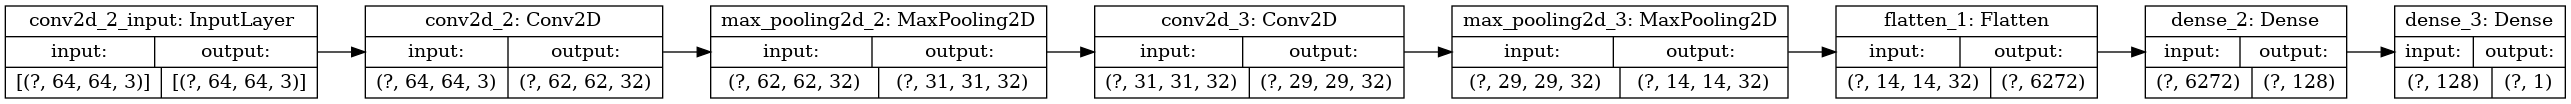

In [111]:
# plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(cnn, to_file='model_plot.png', show_shapes=True, rankdir='LR')

Another tool is Netron [github](https://github.com/lutzroeder/netron) or [online](https://netron.app/):

![](model2.png)

## Training

In [124]:
if 1:
    # adam: stochastic gradient decent
    # loss: binary_crossentropy, this is a binary classifier
    cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    # train cnn - this TAKES A LONG TIME: ~10 MINUTES
    # epoch = 25, how many times to run through the training dataset
    history = cnn.fit(x = training_set, validation_data = test_set, epochs = 40);
else:
    cnn = keras.models.load_model("models")

Epoch 1/40
250/250 [==============================] - 41s 164ms/step - loss: 0.6821 - accuracy: 0.5679 - val_loss: 0.6588 - val_accuracy: 0.6175
Epoch 2/40
250/250 [==============================] - 41s 163ms/step - loss: 0.6318 - accuracy: 0.6525 - val_loss: 0.6100 - val_accuracy: 0.6850
Epoch 3/40
250/250 [==============================] - 46s 185ms/step - loss: 0.5957 - accuracy: 0.6856 - val_loss: 0.6699 - val_accuracy: 0.6490
Epoch 4/40
250/250 [==============================] - 46s 182ms/step - loss: 0.5566 - accuracy: 0.7104 - val_loss: 0.5420 - val_accuracy: 0.7415
Epoch 5/40
250/250 [==============================] - 45s 179ms/step - loss: 0.5344 - accuracy: 0.7258 - val_loss: 0.5336 - val_accuracy: 0.7580
Epoch 6/40
250/250 [==============================] - 48s 194ms/step - loss: 0.5054 - accuracy: 0.7540 - val_loss: 0.6054 - val_accuracy: 0.7165
Epoch 7/40
250/250 [==============================] - 52s 207ms/step - loss: 0.4897 - accuracy: 0.7620 - val_loss: 0.5163 - val_ac

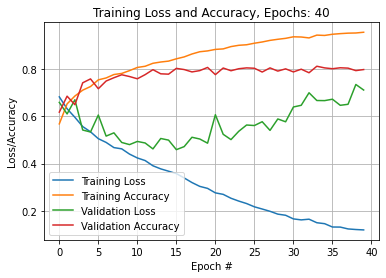

In [125]:
if history:
    H = history
    EPOCHS = len(H.epoch)
    plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="Training Loss")
    plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="Training Accuracy")
    plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="Validation Loss")
    plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"Training Loss and Accuracy, Epochs: {EPOCHS}")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.grid(True);

In [115]:
if 1:
    mkdir("models")
    cnn.save('models/model.h5')
#     cnn.save_weights('models/weights.h5')
#     with open('models/architecture.json', 'w') as f:
#             f.write(cnn.to_json())

In [116]:
dnn = keras.models.load_model("models/model.h5")
dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## Prediction

Given a new image (not from the training set), let's see what the CNN thinks it is! So the way this works is:

- 1.0 == dog
- 0.0 < dog or cat < 1.0
- 0.0 == cat

Now, the closer to 0, the higher the confidence is it is a cat and the closer to 1, the higher the confidence is it is a dog. So we will define 0.5 as the break even point for discriminating dog or cat.

In [117]:
def get_image(fname):
    itest_image = image.load_img(fname, target_size = (64, 64))
    test_image = image.img_to_array(itest_image)
    test_image = np.expand_dims(test_image, axis = 0)

    plt.imshow(itest_image);
    plt.axis('off');
#     plt.title(f"Test Image {itest_image.size}");
    
    return test_image

def predict(nn, img, threshold=0.5):
    result = nn.predict(img)
    result = result[0][0]
    # training_set.class_indices

    # Now, can classify what this is based on the confidence, 50% shown below
    if result > threshold:
      prediction = f'dog: {result:0.1f}'
    else:
      prediction = f'cat: {result:0.1f}'

    print(prediction)

dog: 1.0


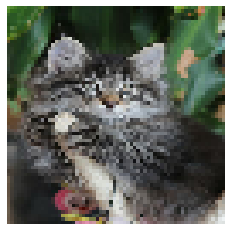

In [118]:
img = get_image('large_dataset/dog-cat-dataset/single_prediction/cat_or_dog_0.jpg')
predict(dnn, img)

dog: 1.0


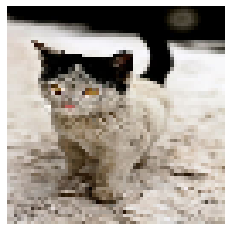

In [119]:
img = get_image('large_dataset/dog-cat-dataset/single_prediction/cat_or_dog_8.jpg')
predict(dnn, img)

In [120]:
if 0:
    to_dataset = "large_dataset/dog-cat-dataset/single_prediction/"
    pics = Path(to_dataset).glob("*.jpg")

    for i, p in enumerate(pics):
        n = Path(to_dataset + f"cat_or_dog_{i}.jpg")
        p.rename(n)
        print(p)

>> 0: cat_or_dog_8  dog: 1.0
>> 1: cat_or_dog_9  cat: 0.0
>> 2: cat_or_dog_0  dog: 1.0
>> 3: cat_or_dog_1  dog: 1.0
>> 4: cat_or_dog_7  dog: 1.0
>> 5: cat_or_dog_4  cat: 0.0
>> 6: cat_or_dog_6  cat: 0.0
>> 7: cat_or_dog_5  cat: 0.0
>> 8: cat_or_dog_2  cat: 0.0
>> 9: cat_or_dog_3  dog: 1.0


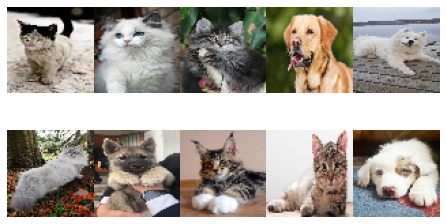

In [126]:
to_dataset = "large_dataset/dog-cat-dataset/single_prediction/"
pics = Path(to_dataset).glob("*.jpg")

for i, p in enumerate(pics):
    print(f">> {i}: {p.stem} ", end=" ")
    plt.subplot(2,5,1 + i)
    img = get_image(p)
    predict(cnn,img)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)